In [1]:
# load necessary libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

In [2]:
def PID(Kp=1, Ti=1, Td=1, t_initial=0, u_bar=0, control_type='pid'):
    """Basic PID controller
    
    args:
    - Kp (int or float) default: 1 = proportional gain
    - Ti (int or float) default: 1 = integral period
    - Td (int or float) default: 1 = derivative period
    - t_initial (int or float) default: 0 = initial time
    - u_bar (int or float) default: 0 = base line for control signal
    - control_type (str) default: 'pid' = choose control type, i.e. either 'p' (proportional only), 'pi' (proportional and integral), 'pd' (proportional and derivative), or 'pid' (full PID)

    yield:
    - u (float) = control signal

    generator send():
    - t, feedback, ref (list-like type) = time, feedback (output from model), and reference
    """
    if not(control_type == 'p' or control_type == 'pi' or control_type == 'pd' or control_type == 'pid'):
        raise ValueError("'control_type' arg only accepts either 'p', 'pi', 'pd', or 'pid'")

    # initialize stored data
    e_prev = 0
    t_prev = t_initial #-100
    I = 0
    
    # initial control
    u = u_bar

    while True:
        # yield MV, wait for new t, PV, SP
        t, feedback, ref = yield u
        
        # PID calculations
        e = ref - feedback
        de = e - e_prev
        dt = t - t_prev

        P = Kp*e
        I = I + e*dt
        D = de/dt
        
        if control_type == 'p':
            u = u_bar + P
        elif control_type == 'pi':
            u = u_bar + Kp*(e + (1/Ti)*I)
        elif control_type == 'pd':
            u = u_bar + Kp*(e + Td*D)
        else:
            u = u_bar + Kp*(e + (1/Ti)*I + Td*D)
        
        # update stored data for next iteration
        e_prev = e
        t_prev = t

In [3]:
def car_dynamics(b, v_in, u, m, dt):
    """Vehicle dynamics model
    
    args:
    - b (int or float) = friction constant (Nm/s)
    - v_in (int or float) = input/initial speed (m/s)
    - u (int or float) = control signal (N)
    - m (int or float) = vehicle mass (kg)
    - dt (int or float) = difference of time (s)

    return:
    v_out (float) = output/final speed (m/s)
    """
    temp = (-b*v_in + u)/m
    v_out = temp*dt + v_in
    return v_out

# PID without tuning

In [23]:
# define constants - arbitrary values
Kp = 500
Ti = 0.5
Td = 0.1
mass = 1000 #kg
frict = 50 #Nm/s

# declare PID controller
controller = PID(Kp=Kp, Ti=Ti, Td=Td)
controller.send(None) # initialize controller

# set speed reference
ref = np.ones(shape=50) * 5

# define useful array variables
feedback = np.zeros(shape=ref.shape)
times = np.arange(start=1, stop=len(ref), step=1)
u = np.zeros(shape=ref.shape)
error = np.zeros(shape=ref.shape)

t_prev = 0 # buffer to store previous time

# loop through each time t
for t in tqdm(times):
    error[t] = ref[t-1] - feedback[t-1] # get error at time t
    u[t] = controller.send([t, feedback[t-1], ref[t-1]]) # calculate PID
    feedback[t] = car_dynamics(b=frict, v_in=feedback[t-1], u=u[t], m=mass, dt=t-t_prev) # calculate model output
    t_prev = t # store for next iteration

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 26413.17it/s]


In [24]:
# MSE
mse_random = np.mean(np.square(error))
print(f"Mean squared error: {round(mse_random, 3)}")

# MAE
mae_random = np.mean(np.absolute(error))
print(f"Mean absolute error: {round(mse_random, 3)}")

# RMSE
rmse_random = np.sqrt(np.mean(np.square(error)))
print(f"Root mean square error: {round(mse_random, 3)}")

Mean squared error: 0.848
Mean absolute error: 0.848
Root mean square error: 0.848


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0, 0.5, 'Error of speed (m/s)')

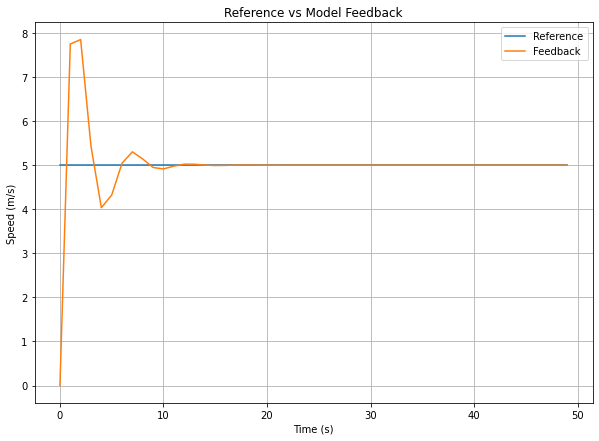

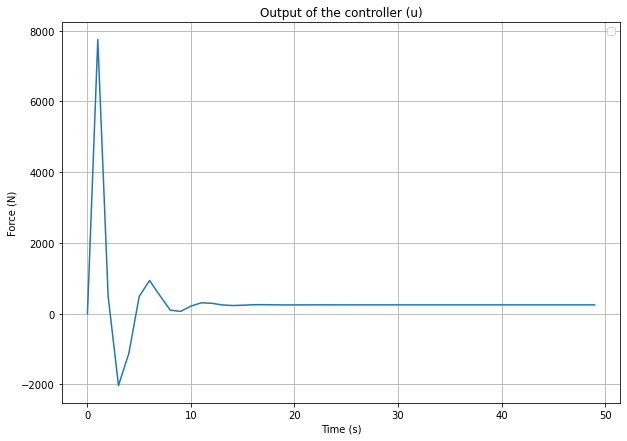

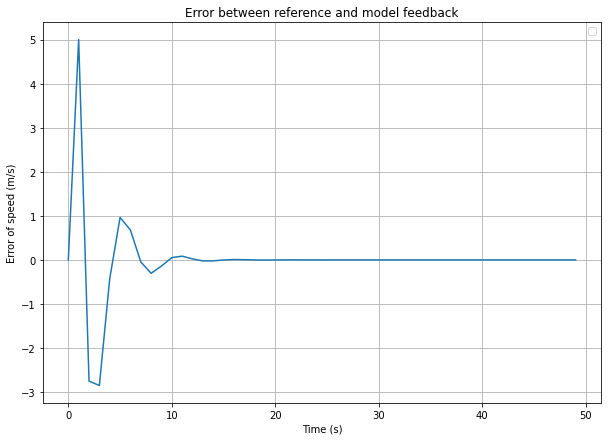

In [6]:
# plot reference vs feedback
plt.figure(figsize=(10,7))
line1, = plt.plot([0] + times.tolist(), ref)
line2, = plt.plot([0] + times.tolist(), feedback)
plt.legend([line1, line2], ['Reference', 'Feedback'])
plt.grid()
plt.title("Reference vs Model Feedback")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")

# plot u
plt.figure(figsize=(10,7))
plt.plot([0] + times.tolist(), u)
plt.legend()
plt.grid()
plt.title("Output of the controller (u)")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")

# plot error
plt.figure(figsize=(10,7))
plt.plot([0] + times.tolist(), error)
plt.legend()
plt.grid()
plt.title("Error between reference and model feedback")
plt.xlabel("Time (s)")
plt.ylabel("Error of speed (m/s)")

# Tuning PID

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 28604.16it/s]


peaks: [9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75
 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75 9.75]
Ku = 1950
Tu = 2.0

Control type 'p':
Kp = 975.0
Ti = _
Td = _


Control type 'pi':
Kp = 877.5
Ti = 1.6
Td = _


Control type 'pd':
Kp = 1560.0
Ti = _
Td = 0.25


Control type 'classic_pid':
Kp = 1170.0
Ti = 1.0
Td = 0.25


Control type 'pessen_integral_rule':
Kp = 1365.0
Ti = 0.8
Td = 0.3


Control type 'some_overshoot':
Kp = 643.5
Ti = 1.0
Td = 0.66


Control type 'no_overshoot':
Kp = 390.0
Ti = 1.0
Td = 0.66


Control type: p
Mean squared error: 0.813
Mean absolute error: 0.381
Root mean square error: 0.902
Control type: pi
Mean squared error: 0.875
Mean absolute error: 0.191
Root mean square error: 0.935
Control type: pd
Mean squared error: 1.3321641385864913e+21
Mean absolute error: 10106066690.519
Root mean square error: 36498823797.302
Control type: classic_pid
Mean squared error: 6.801769279069048e+27
Mean absolute error: 20114961811260.977
Root mean

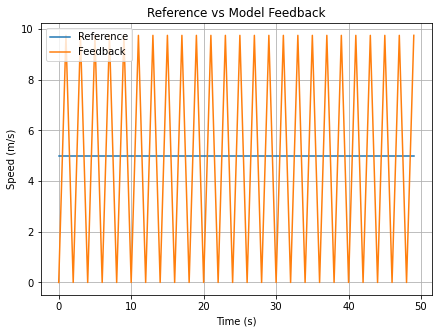

In [22]:
# define constants
Kp = 1950
mass = 1000 #kg
frict = 50 #Nm/s

##################################################
#### STEP 1: USE PROPORTIONAL ONLY ####
#### REPEAT THIS 1ST STEP UNTIL GETTING CONTINUOUS OSCILLATIONS ####

# declare PID controller
controller = PID(Kp=Kp, control_type='p')
controller.send(None) # initialize controller

# set speed reference
ref = np.ones(shape=50) * 5

# define useful array variables
feedback = np.zeros(shape=ref.shape)
times = np.arange(start=1, stop=len(ref), step=1)
u = np.zeros(shape=ref.shape)
error = np.zeros(shape=ref.shape)

t_prev = 0 # buffer to store previous time

# loop through each time t
for t in tqdm(times):
    error[t] = ref[t-1] - feedback[t-1] # get error at time t
    u[t] = controller.send([t, feedback[t-1], ref[t-1]]) # calculate PID
    feedback[t] = car_dynamics(b=frict, v_in=feedback[t-1], u=u[t], m=mass, dt=t-t_prev) # calculate model output
    t_prev = t # store for next iteration

# plot reference vs feedback
plt.figure(figsize=(7,5))
line1, = plt.plot([0] + times.tolist(), ref)
line2, = plt.plot([0] + times.tolist(), feedback)
plt.legend([line1, line2], ['Reference', 'Feedback'])
plt.grid()
plt.title("Reference vs Model Feedback")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")

##################################################
#### STEP 2: GET Ku & Tu AND CALCULATE Kp, Ti, Td ####

# find peaks in feedback signal
peaks, _ = find_peaks(feedback) # get idx of peaks
print('peaks:', feedback[peaks])

# get Ku and Tu
Tu = np.mean(np.diff(peaks))
Ku = Kp
print('Ku =', Ku)
print('Tu =', Tu)
print()

# calculate Kp, Ti, Td using different control type
pid_control_type = {'p': [0.5*Ku, 0, 0],
                    'pi': [0.45*Ku, 0.8*Tu, 0],
                    'pd': [0.8*Ku, 0, 0.125*Tu],
                    'classic_pid': [0.6*Ku, 0.5*Tu, 0.125*Tu],
                    'pessen_integral_rule': [0.7*Ku, 0.4*Tu, 0.15*Tu],
                    'some_overshoot': [0.33*Ku, 0.5*Tu, 0.33*Tu],
                    'no_overshoot': [0.2*Ku, 0.5*Tu, 0.33*Tu]}

for key, value in pid_control_type.items():
    print(f"Control type '{key}':")
    print(f"Kp = {value[0] if value[0] != 0 else '_'}")
    print(f"Ti = {value[1] if value[1] != 0 else '_'}")
    print(f"Td = {value[2] if value[2] != 0 else '_'}")
    print('\n')

##################################################
#### STEP 3: RUN ALL CONTROLLER TYPES USING CONSTANTS JUST OBTAINED ####

# buffer
ref_list = []
feedback_list = []
MSE_list = []
MAE_list = []
RMSE_list = []

# loop each control_type
for key, value in pid_control_type.items():
    # get constants
    Kp = value[0]
    Ti = value[1]
    Td = value[2]

    # set control_type arg for PID function
    if key == 'p' or key == 'pi' or key == 'pd':
        control_type = key
    else:
        control_type = 'pid'

    print('==================================================')
    print(f"Control type: {key}")
    print('==================================================')

    # declare PID controller
    controller = PID(Kp=Kp, Ti=Ti, Td=Td, control_type=control_type)
    controller.send(None) # initialize controller

    # set speed reference
    ref = np.concatenate((np.ones(shape=50) * 2, np.ones(shape=50) * 10))

    # define useful array variables
    feedback = np.zeros(shape=ref.shape)
    times = np.arange(start=1, stop=len(ref), step=1)
    u = np.zeros(shape=ref.shape)
    error = np.zeros(shape=ref.shape)

    t_prev = 0 # buffer to store previous time

    # loop through each time t
    for t in times:
        error[t] = ref[t-1] - feedback[t-1] # get error at time t
        u[t] = controller.send([t, feedback[t-1], ref[t-1]]) # calculate PID
        feedback[t] = car_dynamics(b=frict, v_in=feedback[t-1], u=u[t], m=mass, dt=t-t_prev) # calculate model output
        t_prev = t # store for next iteration

    # store ref and feedback
    ref_list.append(ref)
    feedback_list.append(feedback)

    # MSE
    mse = np.mean(np.square(error))
    print(f"Mean squared error: {round(mse, 3)}")
    MSE_list.append(mse)

    # MAE
    mae = np.mean(np.absolute(error))
    print(f"Mean absolute error: {round(mae, 3)}")
    MAE_list.append(mae)

    # RMSE
    rmse = np.sqrt(np.mean(np.square(error)))
    print(f"Root mean square error: {round(rmse, 3)}")
    RMSE_list.append(rmse)

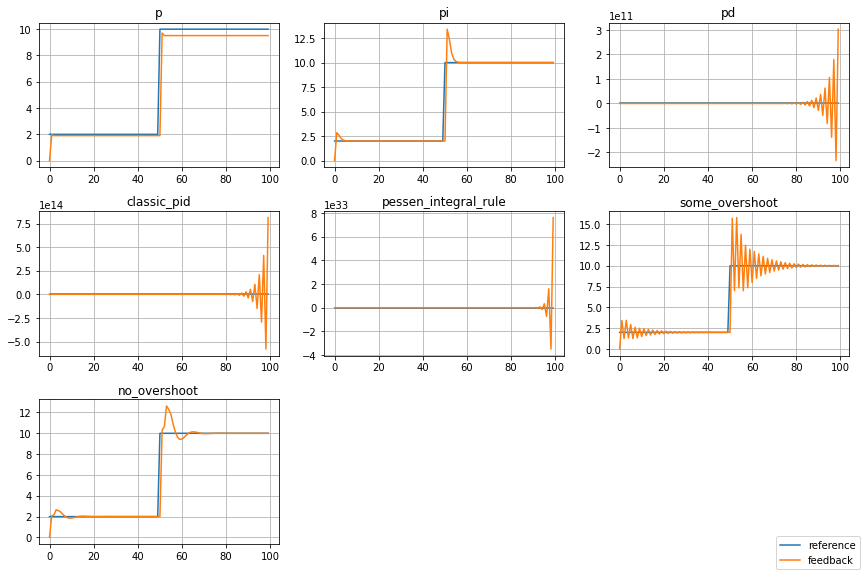

In [11]:
# plot all 7 controllers
fig, axs = plt.subplots(3, 3, figsize=(12,8))
axs[0,0].plot([0] + times.tolist(), ref_list[0])
axs[0,0].plot([0] + times.tolist(), feedback_list[0])
axs[0,0].set_title(list(pid_control_type.keys())[0])
axs[0,0].grid()

axs[0,1].plot([0] + times.tolist(), ref_list[1])
axs[0,1].plot([0] + times.tolist(), feedback_list[1])
axs[0,1].set_title(list(pid_control_type.keys())[1])
axs[0,1].grid()

axs[0,2].plot([0] + times.tolist(), ref_list[2])
axs[0,2].plot([0] + times.tolist(), feedback_list[2])
axs[0,2].set_title(list(pid_control_type.keys())[2])
axs[0,2].grid()

axs[1,0].plot([0] + times.tolist(), ref_list[3])
axs[1,0].plot([0] + times.tolist(), feedback_list[3])
axs[1,0].set_title(list(pid_control_type.keys())[3])
axs[1,0].grid()

axs[1,1].plot([0] + times.tolist(), ref_list[4])
axs[1,1].plot([0] + times.tolist(), feedback_list[4])
axs[1,1].set_title(list(pid_control_type.keys())[4])
axs[1,1].grid()

axs[1,2].plot([0] + times.tolist(), ref_list[5])
axs[1,2].plot([0] + times.tolist(), feedback_list[5])
axs[1,2].set_title(list(pid_control_type.keys())[5])
axs[1,2].grid()

line1, = axs[2,0].plot([0] + times.tolist(), ref_list[6])
line2, = axs[2,0].plot([0] + times.tolist(), feedback_list[6])
axs[2,0].set_title(list(pid_control_type.keys())[6])
axs[2,0].grid()

fig.delaxes(axs[2,1])
fig.delaxes(axs[2,2])

fig.legend((line1, line2), ('reference', 'feedback'), loc='lower right')

fig.tight_layout()

In [26]:
# create dataframe for MSE, MAE, RMSE
df = pd.DataFrame([list(pid_control_type.keys()) + ['no_tuning'], MSE_list + [mse_random], MAE_list + [mae_random], RMSE_list + [rmse_random]])
df = df.transpose()
df.columns = ['control_type', 'MSE', 'MAE', 'RMSE']

In [27]:
df

,control_type,MSE,MAE,RMSE
0,p,0.81307,0.380607,0.901704
1,pi,0.874739,0.190883,0.935275
2,pd,1.33216e+21,1.01061e+10,3.64988e+10
3,classic_pid,6.80177e+27,2.0115e+13,8.24728e+13
4,pessen_integral_rule,1.5474e+65,6.45382e+31,3.9337e+32
5,some_overshoot,2.18385,0.717865,1.47779
6,no_overshoot,0.867989,0.242128,0.931659
7,no_tuning,0.84763,0.267652,0.920668
